In [1]:
# FIX FOR RTX 5080 / CUDA 12 HARDWARE
# This cell patches the environment to ensure TensorFlow finds the GPU correctly
import os
import sys
import ctypes

def preload_nvidia_libs():
    try:
        # Attempt to locate site-packages content
        paths_to_check = []
        if hasattr(sys, 'prefix'):
            paths_to_check.append(os.path.join(sys.prefix, "lib", f"python{sys.version_info.major}.{sys.version_info.minor}", "site-packages", "nvidia"))
        
        nvidia_base = None
        for p in paths_to_check:
            if os.path.exists(p):
                nvidia_base = p
                break
        
        if not nvidia_base:
            print("Could not find nvidia packages to preload. GPU might not be detected.")
            return

        libs_to_load = [
            ("cudnn/lib", "libcudnn.so.9"),
            ("cublas/lib", "libcublas.so.12"),
            ("cublas/lib", "libcublasLt.so.12"),
            ("cufft/lib", "libcufft.so.11"),
            ("curand/lib", "libcurand.so.10"),
            ("cusolver/lib", "libcusolver.so.11"),
            ("cusparse/lib", "libcusparse.so.12"),
            ("nccl/lib", "libnccl.so.2"),
        ]
        
        print(f"Preloading NVIDIA libraries from {nvidia_base}...")
        for subdir, libname in libs_to_load:
            path = os.path.join(nvidia_base, subdir, libname)
            if os.path.exists(path):
                try:
                    ctypes.CDLL(path)
                except Exception as e:
                    print(f"Warning: Failed to load {libname}: {e}")
        print("NVIDIA libraries preloaded.")
    except Exception as e:
        print(f"Error during preload: {e}")

preload_nvidia_libs()


Preloading NVIDIA libraries from /home/fabit/brain-tumor-detection/.venv/lib/python3.12/site-packages/nvidia...
NVIDIA libraries preloaded.


# TASK #2: IMPORT LIBRARIES AND DATASETS

In [2]:
# Configuration and paths
import os
from pathlib import Path

# Set base directory
BASE_DIR = Path.cwd()
DATA_DIR = BASE_DIR / 'data'
MODELS_DIR = BASE_DIR / 'models'

# Ensure directories exist
DATA_DIR.mkdir(exist_ok=True)
MODELS_DIR.mkdir(exist_ok=True)

# Configuration constants
BATCH_SIZE = 64
LEARNING_RATE = 1e-4
IMAGE_SIZE = (256, 256)
EPOCHS = 100

# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import cv2
from skimage import io
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, roc_auc_score,RocCurveDisplay, precision_score, f1_score
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import glob
import random
%matplotlib inline

I0000 00:00:1765245697.313368  153867 port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
I0000 00:00:1765245697.343756  153867 cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
I0000 00:00:1765245698.000418  153867 port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [3]:
# Google Colab code removed - running locally
# Data should be in the 'data' directory relative to the notebook

In [4]:
# Google Colab directory change removed - running locally
# Working directory is already set to the project root


In [5]:
# Load data from data directory
brain_df = pd.read_csv(DATA_DIR / 'route_label.csv', index_col=0)

In [6]:
# Custom Callback that forces printing to stdout to ensure visibility
from tensorflow.keras.callbacks import Callback

class ForceProgressPrint(Callback):
    def on_epoch_begin(self, epoch, logs=None):
        print(f'\n🚀 Starting Epoch {epoch + 1}...')

    def on_train_batch_end(self, batch, logs=None):
        if batch % 10 == 0:  # Print every 10 batches
            loss = logs.get('loss', 0)
            acc = logs.get('accuracy', 0)
            print(f'   Batch {batch}: Loss = {loss:.4f}, Accuracy = {acc:.4f}')


# DATA

In [7]:
# Get the dataframe containing MRIs which have masks associated with them.
brain_df_mask = brain_df[brain_df['mask'] == 1]
brain_df_mask.to_csv(DATA_DIR / "segmentation_routes_labels.csv")
brain_df_mask.shape

(1366, 3)

In [8]:
# Improved Data Splitting to prevent Data Leakage
# splitting by patient_id instead of random shuffle
from sklearn.model_selection import GroupShuffleSplit

# Extract patient ID (Assuming format TCGA_XX_YYYY_DATE_SLICE)
# ID is the first 3 parts: TCGA_XX_YYYY
brain_df_mask['patient_id'] = brain_df_mask['image_path'].apply(lambda x: "_".join(str(x).split('/')[-2].split('_')[:3]))

print("Total patients:", brain_df_mask['patient_id'].nunique())

# 80% Train, 20% Val+Test
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, val_test_idx = next(gss.split(brain_df_mask, groups=brain_df_mask['patient_id']))

brain_df_mask_train = brain_df_mask.iloc[train_idx]
brain_df_mask_val_test = brain_df_mask.iloc[val_test_idx]

# Split Val+Test into 50% Val, 50% Test (so 10% each of total)
gss_val = GroupShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
val_idx, test_idx = next(gss_val.split(brain_df_mask_val_test, groups=brain_df_mask_val_test['patient_id']))

brain_df_mask_val = brain_df_mask_val_test.iloc[val_idx]
brain_df_mask_test = brain_df_mask_val_test.iloc[test_idx]

print(f"Train: {len(brain_df_mask_train)} images")
print(f"Val:   {len(brain_df_mask_val)} images")
print(f"Test:  {len(brain_df_mask_test)} images")


Total patients: 109
Train: 1071 images
Val:   166 images
Test:  129 images


/tmp/ipykernel_153867/2577546803.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  brain_df_mask['patient_id'] = brain_df_mask['image_path'].apply(lambda x: "_".join(str(x).split('/')[-2].split('_')[:3]))


In [9]:
# Save train/test/val splits to data directory
brain_df_mask_train.to_csv(DATA_DIR / "segmentation_train.csv")
brain_df_mask_test.to_csv(DATA_DIR / "segmentation_test.csv")
brain_df_mask_val.to_csv(DATA_DIR / "segmentation_validation.csv")

In [10]:
BATCH_SIZE = 16

In [11]:
# Seed for synchronizing image and mask augmentations
SEED = 42

# Generator WITH augmentation for training
# Increased parameters for robust training with larger model
train_datagen = ImageDataGenerator(
    rescale=1./255.,
    rotation_range=15,        # Increased from 10
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    zoom_range=0.15,          # Increased from 0.1
    horizontal_flip=True,
    fill_mode='nearest'
)

# Generator WITHOUT augmentation for validation/test
val_datagen = ImageDataGenerator(rescale=1./255.)


In [12]:
def train_generator_fn():
    """Training generator with synchronized augmentation for image and mask."""
    image_generator = train_datagen.flow_from_dataframe(
        brain_df_mask_train,
        x_col='image_path',
        class_mode=None,
        color_mode="rgb",
        target_size=(256, 256),
        batch_size=BATCH_SIZE,
        seed=SEED,  # Same seed for synchronization
        shuffle=True
    )

    mask_generator = train_datagen.flow_from_dataframe(
        brain_df_mask_train,
        x_col="mask_path",
        class_mode=None,
        color_mode="grayscale",
        target_size=(256, 256),
        batch_size=BATCH_SIZE,
        seed=SEED,  # Same seed - ensures identical transformations
        shuffle=True
    )

    while True:
        img = next(image_generator)
        msk = next(mask_generator)
        # Binarize masks (augmentation can create intermediate values)
        msk = (msk > 0.5).astype(np.float32)
        yield (img, msk)

training_generator = train_generator_fn()


def val_generator_fn():
    """Validation generator WITHOUT augmentation."""
    image_generator_val = val_datagen.flow_from_dataframe(
        brain_df_mask_val,
        x_col='image_path',
        class_mode=None,
        color_mode="rgb",
        target_size=(256, 256),
        batch_size=BATCH_SIZE,
        seed=SEED,
        shuffle=False  # No shuffle for validation
    )

    mask_generator_val = val_datagen.flow_from_dataframe(
        brain_df_mask_val,
        x_col="mask_path",
        class_mode=None,
        color_mode="grayscale",
        target_size=(256, 256),
        batch_size=BATCH_SIZE,
        seed=SEED,
        shuffle=False
    )

    while True:
        img = next(image_generator_val)
        msk = next(mask_generator_val)
        # Binarize masks
        msk = (msk > 0.5).astype(np.float32)
        yield (img, msk)

validation_generator = val_generator_fn()


In [13]:
# --- Attention Gates and Squeeze-and-Excitation Blocks ---
# Implemented by Antigravity for Model Architecture Optimization

from tensorflow.keras.layers import GlobalAveragePooling2D, Reshape, Dense, Multiply, Permute

def squeeze_excite_block(input, ratio=16):
    init = input
    channel_axis = -1
    filters = init.shape[channel_axis]
    se_shape = (1, 1, filters)

    se = GlobalAveragePooling2D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)

    x = Multiply()([init, se])
    return x

def attention_gate(F_g, F_l, F_int):
    """
    F_g: Gating signal (from lower layer)
    F_l: Skip connection (from encoder)
    F_int: Intermediate filters
    """
    # Gating signal processing
    g = Conv2D(F_int, kernel_size=1, strides=1, padding='valid', kernel_initializer='he_normal')(F_g)
    g = BatchNormalization()(g)
    
    # Skip connection processing
    x = Conv2D(F_int, kernel_size=1, strides=1, padding='valid', kernel_initializer='he_normal')(F_l)
    x = BatchNormalization()(x)
    
    # Combine
    psi = Add()([g, x])
    psi = Activation('relu')(psi)
    
    # Attention Coefficients
    psi = Conv2D(1, kernel_size=1, strides=1, padding='valid', kernel_initializer='he_normal')(psi)
    psi = BatchNormalization()(psi)
    psi = Activation('sigmoid')(psi)
    
    # Apply Attention
    return Multiply()([F_l, psi])


In [14]:
from tensorflow.keras.layers import SpatialDropout2D

def resblock(X, f):
  # make a copy of input
  X_copy = X

  # main path
  X = Conv2D(f, kernel_size = (1,1) ,strides = (1,1),kernel_initializer ='he_normal')(X)
  X = BatchNormalization()(X)
  X = Activation('relu')(X)
  
  # Spatial Dropout to prevent overfitting features in large model
  X = SpatialDropout2D(0.1)(X) # Mild dropout

  X = Conv2D(f, kernel_size = (3,3), strides =(1,1), padding = 'same', kernel_initializer ='he_normal')(X)
  X = BatchNormalization()(X)

  # Short path
  X_copy = Conv2D(f, kernel_size = (1,1), strides =(1,1), kernel_initializer ='he_normal')(X_copy)
  X_copy = BatchNormalization()(X_copy)

  # Adding the output from main path and short path together
  X = Add()([X,X_copy])
  X = Activation('relu')(X)
  
  # Add Squeeze-and-Excitation Block
  X = squeeze_excite_block(X)
  
  return X


In [15]:
def upsample_attention(x, skip, filters):
  x = UpSampling2D((2,2))(x)
  
  # Apply Attention Gate to the skip connection
  # filters // 2 is a common heuristic for intermediate channels
  skip_att = attention_gate(F_g=x, F_l=skip, F_int=filters // 2)
  
  merge = Concatenate()([x, skip_att])
  return merge


In [16]:
input_shape = (256,256,3)

# Input tensor shape
X_input = Input(input_shape)

# Stage 1
conv1_in = Conv2D(32,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(X_input)
conv1_in = BatchNormalization()(conv1_in)
conv1_in = Conv2D(32,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(conv1_in)
conv1_in = BatchNormalization()(conv1_in)
pool_1 = MaxPool2D(pool_size = (2,2))(conv1_in)

# Stage 2
conv2_in = resblock(pool_1, 64)
pool_2 = MaxPool2D(pool_size = (2,2))(conv2_in)

# Stage 3
conv3_in = resblock(pool_2, 128)
pool_3 = MaxPool2D(pool_size = (2,2))(conv3_in)

# Stage 4
conv4_in = resblock(pool_3, 256)
pool_4 = MaxPool2D(pool_size = (2,2))(conv4_in)

# Stage 5 (Bottle Neck)
conv5_in = resblock(pool_4, 512)

# Upscale Stage 1 (Attention)
up_1 = upsample_attention(conv5_in, conv4_in, 256)
up_1 = resblock(up_1, 256)

# Upscale Stage 2 (Attention)
up_2 = upsample_attention(up_1, conv3_in, 128)
up_2 = resblock(up_2, 128)

# Upscale Stage 3 (Attention)
up_3 = upsample_attention(up_2, conv2_in, 64)
up_3 = resblock(up_3, 64)

# Upscale Stage 4 (Attention)
up_4 = upsample_attention(up_3, conv1_in, 32)
up_4 = resblock(up_4, 32)

# Final Output
output = Conv2D(1, (1,1), padding = "same", activation = "sigmoid")(up_4)

model_seg = Model(inputs = X_input, outputs = output )


W0000 00:00:1765245698.339534  153867 cuda_executor.cc:1840] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.
W0000 00:00:1765245698.339871  153867 cuda_executor.cc:1840] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.
W0000 00:00:1765245698.340165  153867 cuda_executor.cc:1840] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.
W0000 00:00:1765245698.340179  153867 gpu_device.cc:2456] TensorFlow was not built with CUDA kernel binaries compatible with compute capability 12.0a. CUDA kernels will be jit-compiled from PTX, which could take 30 minutes or longer.
W0000 00:00:1765245698.342831  153867 cuda_executor.cc:1840] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not us

In [17]:
model_seg.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │      2,112 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout2d   │ (None, 128, 128,  │          0 │ activation[0][0]  │
│ (SpatialDropout2D)  │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │     36,928 │ spatial_dropout2… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 128, 128,  │      2,112 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 128, 128,  │          0 │ add[0][0]         │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ activation_1[0][

 Total params: 5,006,853 (19.10 MB)

 Trainable params: 4,997,117 (19.06 MB)

 Non-trainable params: 9,736 (38.03 KB)

In [18]:
# --- Custom Metrics ---
# Restored by Antigravity
import tensorflow.keras.backend as K

def dice_coef(y_true, y_pred, smooth=1):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2. * intersection + smooth) / (K.sum(K.square(y_true), -1) + K.sum(K.square(y_pred), -1) + smooth)

def iou_coef(y_true, y_pred, smooth=1):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    union = K.sum(y_true,-1) + K.sum(y_pred,-1) - intersection
    return (intersection + smooth) / (union + smooth)


In [19]:
# === IMPROVED LOSS FUNCTIONS (FIXED) ===
# Combo Loss: Dice + BCE for boundary precision

import tensorflow as tf
import tensorflow.keras.backend as K

def dice_loss(y_true, y_pred, smooth=1):
    '''Dice Loss for area overlap.'''
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def weighted_bce_loss(y_true, y_pred):
    '''
    Binary Cross-Entropy with edge weighting.
    Pixels near edges get higher weight.
    '''
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    # Compute edge weight map using dilation - erosion
    kernel = tf.ones((3, 3, 1, 1), dtype=tf.float32)
    
    # Dilate
    dilated = tf.nn.conv2d(y_true, kernel, strides=[1,1,1,1], padding='SAME')
    dilated = tf.cast(dilated > 0, tf.float32)
    
    # Erode (dilate the inverse)
    eroded = 1 - tf.nn.conv2d(1 - y_true, kernel, strides=[1,1,1,1], padding='SAME')
    eroded = tf.cast(eroded > 0, tf.float32)
    
    # Edge = dilated - eroded
    edge_weight = tf.abs(dilated - eroded)
    
    # Weight: 1.0 base + 2.0 extra for edges
    weights = 1.0 + 2.0 * edge_weight
    
    # Standard BCE
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    bce = tf.expand_dims(bce, -1)  # Match shape
    
    # Weighted average
    weighted_bce = bce * weights
    return K.mean(weighted_bce)

def combo_loss(y_true, y_pred):
    '''
    Combined loss: Dice (50%) + Weighted BCE (50%)
    - Dice: Optimizes area overlap
    - Weighted BCE: Penalizes boundary errors more
    '''
    dice = dice_loss(y_true, y_pred)
    w_bce = weighted_bce_loss(y_true, y_pred)
    
    return 0.5 * dice + 0.5 * w_bce

print('Combo Loss (Dice + Weighted BCE) ready.')


Combo Loss (Dice + Weighted BCE) ready.


In [20]:
# === ADAPTIVE MORPHOLOGICAL POST-PROCESSING ===
# Only erodes large tumors, preserves small ones

import cv2
import numpy as np

def adaptive_morphology(mask, size_threshold=500):
    '''
    Apply erosion only to large connected components.
    Small tumors are preserved without erosion.
    
    Args:
        mask: Binary mask (H, W) or (H, W, 1)
        size_threshold: Components larger than this get eroded
    '''
    # Handle 3D input
    squeeze = False
    if len(mask.shape) == 3:
        mask = mask.squeeze()
        squeeze = True
    
    mask = mask.astype(np.uint8)
    
    # Find connected components
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(mask, connectivity=8)
    
    result = np.zeros_like(mask)
    kernel = np.ones((3, 3), np.uint8)
    
    for label in range(1, num_labels):  # Skip background (0)
        component = (labels == label).astype(np.uint8)
        area = stats[label, cv2.CC_STAT_AREA]
        
        if area > size_threshold:
            # Large tumor: apply erosion to shrink
            component = cv2.erode(component, kernel, iterations=1)
        # Small tumors: keep original (no erosion)
        
        result = np.maximum(result, component)
    
    if squeeze:
        result = np.expand_dims(result, -1)
    
    return result

print('Adaptive Morphology ready (preserves small tumors).')


Adaptive Morphology ready (preserves small tumors).


In [21]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

# Callbacks - Monitoring Dice Coefficient (Maximizing it)
checkpoint = ModelCheckpoint(str(MODELS_DIR / 'segmentation_ResUNet6.keras'), verbose=1, save_best_only=True, monitor='val_dice_coef', mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_dice_coef', factor=0.1, patience=5, verbose=1, min_lr=1e-6, mode='max')
early_stopping = EarlyStopping(monitor='val_dice_coef', patience=12, verbose=1, restore_best_weights=True, mode='max')

# Define ForceProgressPrint if it wasn't defined earlier, but it should be.
callbacks = [checkpoint, reduce_lr, early_stopping, ForceProgressPrint()]

print("Compiling Model...")
# Use the new Focal Tversky loss and per-sample metrics
model_seg.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), 
                  loss=combo_loss, 
                  metrics=[dice_coef, iou_coef, 'accuracy'])

print("Starting Training...")
history = model_seg.fit(
    training_generator,
    steps_per_epoch=len(brain_df_mask_train) // BATCH_SIZE,
    validation_data=validation_generator,
    validation_steps=len(brain_df_mask_val) // BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callbacks
)


Compiling Model...
Starting Training...
Found 1071 validated image filenames.
Found 1071 validated image filenames.

🚀 Starting Epoch 1...
Epoch 1/100


I0000 00:00:1765245708.187960  153960 service.cc:153] XLA service 0x7cf6800b8df0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1765245708.188000  153960 service.cc:161]   StreamExecutor device (0): NVIDIA GeForce RTX 5080, Compute Capability 12.0a
I0000 00:00:1765245708.412333  153960 dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1765245710.006021  153960 cuda_dnn.cc:461] Loaded cuDNN version 91700
I0000 00:00:1765245724.211918  154078 subprocess_compilation.cc:348] ptxas warning : Registers are spilled to local memory in function 'input_add_reduce_fusion_15', 8 bytes spill stores, 8 bytes spill loads

I0000 00:00:1765245733.252486  153960 subprocess_compilation.cc:348] ptxas warning : Registers are spilled to local memory in function 'input_add_reduce_fusion_15', 8 bytes spill stores, 8 bytes spill loads

I0000 00:00:1765245733.328010  153960 device_comp

   Batch 0: Loss = 0.7805, Accuracy = 0.7821
10/66 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - accuracy: 0.8096 - dice_coef: 0.8448 - iou_coef: 0.7091 - loss: 0.7614   Batch 10: Loss = 0.7371, Accuracy = 0.8431
20/66 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - accuracy: 0.8367 - dice_coef: 0.8553 - iou_coef: 0.7188 - loss: 0.7405   Batch 20: Loss = 0.6981, Accuracy = 0.8858
30/66 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - accuracy: 0.8568 - dice_coef: 0.8645 - iou_coef: 0.7279 - loss: 0.7220   Batch 30: Loss = 0.6711, Accuracy = 0.9082
40/66 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - accuracy: 0.8715 - dice_coef: 0.8723 - iou_coef: 0.7361 - loss: 0.7069   Batch 40: Loss = 0.6504, Accuracy = 0.9234
50/66 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 0.8828 - dice_coef: 0.8791 - iou_coef: 0.7436 - loss: 0.6939   Batch 50: Loss = 0.6315, Accuracy = 0.9336
60/66 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.8919 - dice_coef: 0.8852 - iou_coef: 0.7505 - loss: 0.6822   Batch 60: Loss = 0.6140, Accuracy = 0.9412
66/66 ━

I0000 00:00:1765245756.136553  155865 subprocess_compilation.cc:348] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_8', 40 bytes spill stores, 40 bytes spill loads

I0000 00:00:1765245757.728126  155865 subprocess_compilation.cc:348] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_9', 8 bytes spill stores, 8 bytes spill loads

I0000 00:00:1765245758.815921  155863 subprocess_compilation.cc:348] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_7', 48 bytes spill stores, 48 bytes spill loads

I0000 00:00:1765245766.472645  153961 subprocess_compilation.cc:348] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_2', 40 bytes spill stores, 40 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_3', 48 bytes spill stores, 48 bytes spill loads
ptxas warning

   Batch 0: Loss = 0.5284, Accuracy = 0.9667
10/66 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - accuracy: 0.9687 - dice_coef: 0.9641 - iou_coef: 0.8611 - loss: 0.5245   Batch 10: Loss = 0.5024, Accuracy = 0.9754
20/66 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - accuracy: 0.9731 - dice_coef: 0.9668 - iou_coef: 0.8655 - loss: 0.5097   Batch 20: Loss = 0.4887, Accuracy = 0.9792
30/66 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - accuracy: 0.9755 - dice_coef: 0.9686 - iou_coef: 0.8688 - loss: 0.5019   Batch 30: Loss = 0.4806, Accuracy = 0.9810
40/66 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - accuracy: 0.9769 - dice_coef: 0.9700 - iou_coef: 0.8716 - loss: 0.4958   Batch 40: Loss = 0.4729, Accuracy = 0.9813
50/66 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 0.9778 - dice_coef: 0.9711 - iou_coef: 0.8740 - loss: 0.4906   Batch 50: Loss = 0.4664, Accuracy = 0.9817
60/66 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.9785 - dice_coef: 0.9720 - iou_coef: 0.8763 - loss: 0.4861   Batch 60: Loss = 0.4608, Accuracy = 0.9818
66/66 ━

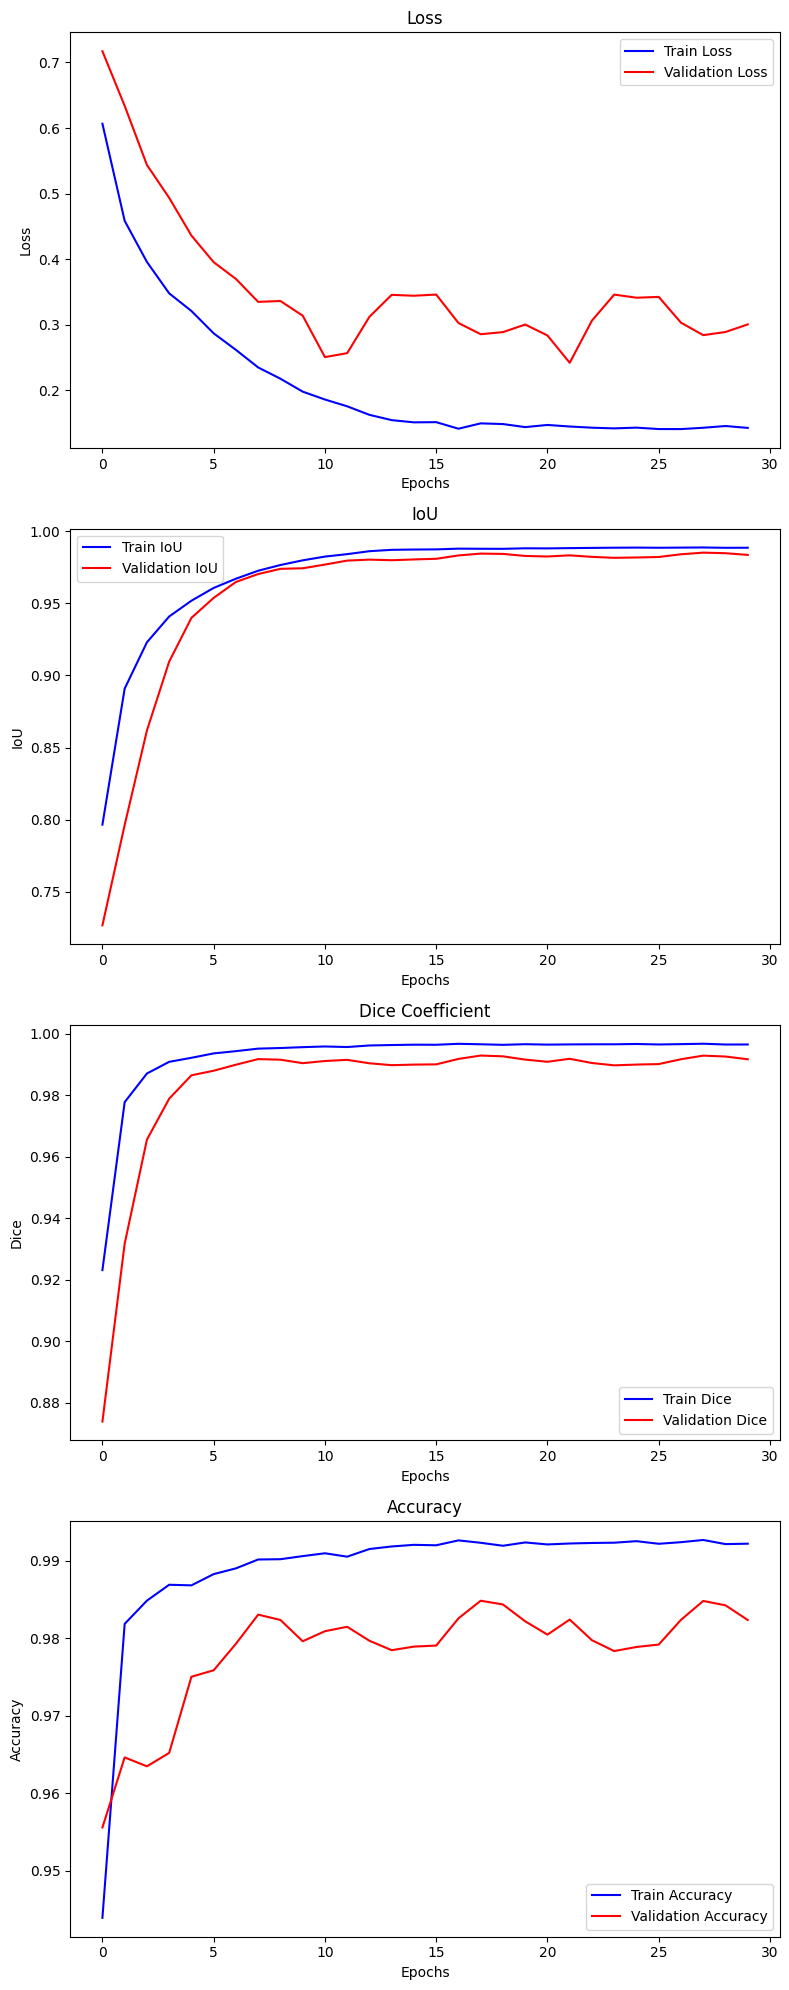

In [22]:
# Evaluation Visualization
plt.figure(figsize=(8, 20))

# --- Loss ---
plt.subplot(4, 1, 1)
plt.plot(history.history['loss'], 'b-', label='Train Loss')
plt.plot(history.history['val_loss'], 'r-', label='Validation Loss')
plt.legend(loc='best')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# --- IoU ---
plt.subplot(4, 1, 2)
plt.plot(history.history['iou_coef'], 'b-', label='Train IoU')
plt.plot(history.history['val_iou_coef'], 'r-', label='Validation IoU')
plt.legend(loc='best')
plt.title('IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')

# --- Dice Coefficient ---
plt.subplot(4, 1, 3)
plt.plot(history.history['dice_coef'], 'b-', label='Train Dice')
plt.plot(history.history['val_dice_coef'], 'r-', label='Validation Dice')
plt.legend(loc='best')
plt.title('Dice Coefficient')
plt.xlabel('Epochs')
plt.ylabel('Dice')

plt.subplot(4, 1, 4)
plt.plot(history.history['accuracy'], 'b-', label='Train Accuracy')
plt.plot(history.history['val_accuracy'], 'r-', label='Validation Accuracy')
plt.legend(loc='best')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

In [23]:
loaded_model_seg=load_model(str(MODELS_DIR / "segmentation_ResUNet6.keras"), custom_objects={"combo_loss":combo_loss, "dice_coef":dice_coef, "iou_coef":iou_coef})

In [24]:
def test_generator_fn():
    """Test generator WITHOUT augmentation - uses val_datagen."""
    image_generator_test = val_datagen.flow_from_dataframe(
        brain_df_mask_test,
        x_col='image_path',
        class_mode=None,
        color_mode="rgb",
        target_size=(256, 256),
        batch_size=BATCH_SIZE,
        seed=SEED,
        shuffle=False  # No shuffle for test
    )

    mask_generator_test = val_datagen.flow_from_dataframe(
        brain_df_mask_test,
        x_col="mask_path",
        class_mode=None,
        color_mode="grayscale",
        target_size=(256, 256),
        batch_size=BATCH_SIZE,
        seed=SEED,
        shuffle=False
    )

    while True:
        img = next(image_generator_test)
        msk = next(mask_generator_test)
        # Binarize masks
        msk = (msk > 0.5).astype(np.float32)
        yield (img, msk)

test_generator = test_generator_fn()


In [25]:

loaded_model_seg=load_model(str(MODELS_DIR / "segmentation_ResUNet6.keras"), custom_objects={"combo_loss":combo_loss, "dice_coef":dice_coef, "iou_coef":iou_coef})
prediction_seg = loaded_model_seg.evaluate(test_generator, steps=len(brain_df_mask_test) // BATCH_SIZE, verbose=1)

Found 129 validated image filenames.
Found 129 validated image filenames.
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.9864 - dice_coef: 0.9939 - iou_coef: 0.9849 - loss: 0.2006


In [26]:
print(f" Test Accuracy: {prediction_seg[3]:.4f}")
print(f" Test Dice Coefficient: {prediction_seg[1]:.4f}")
print(f" Test IoU: {prediction_seg[2]:.4f}")
print(f" Test Loss: {prediction_seg[0]:.4f}")

 Test Accuracy: 0.9864
 Test Dice Coefficient: 0.9939
 Test IoU: 0.9849
 Test Loss: 0.2006


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


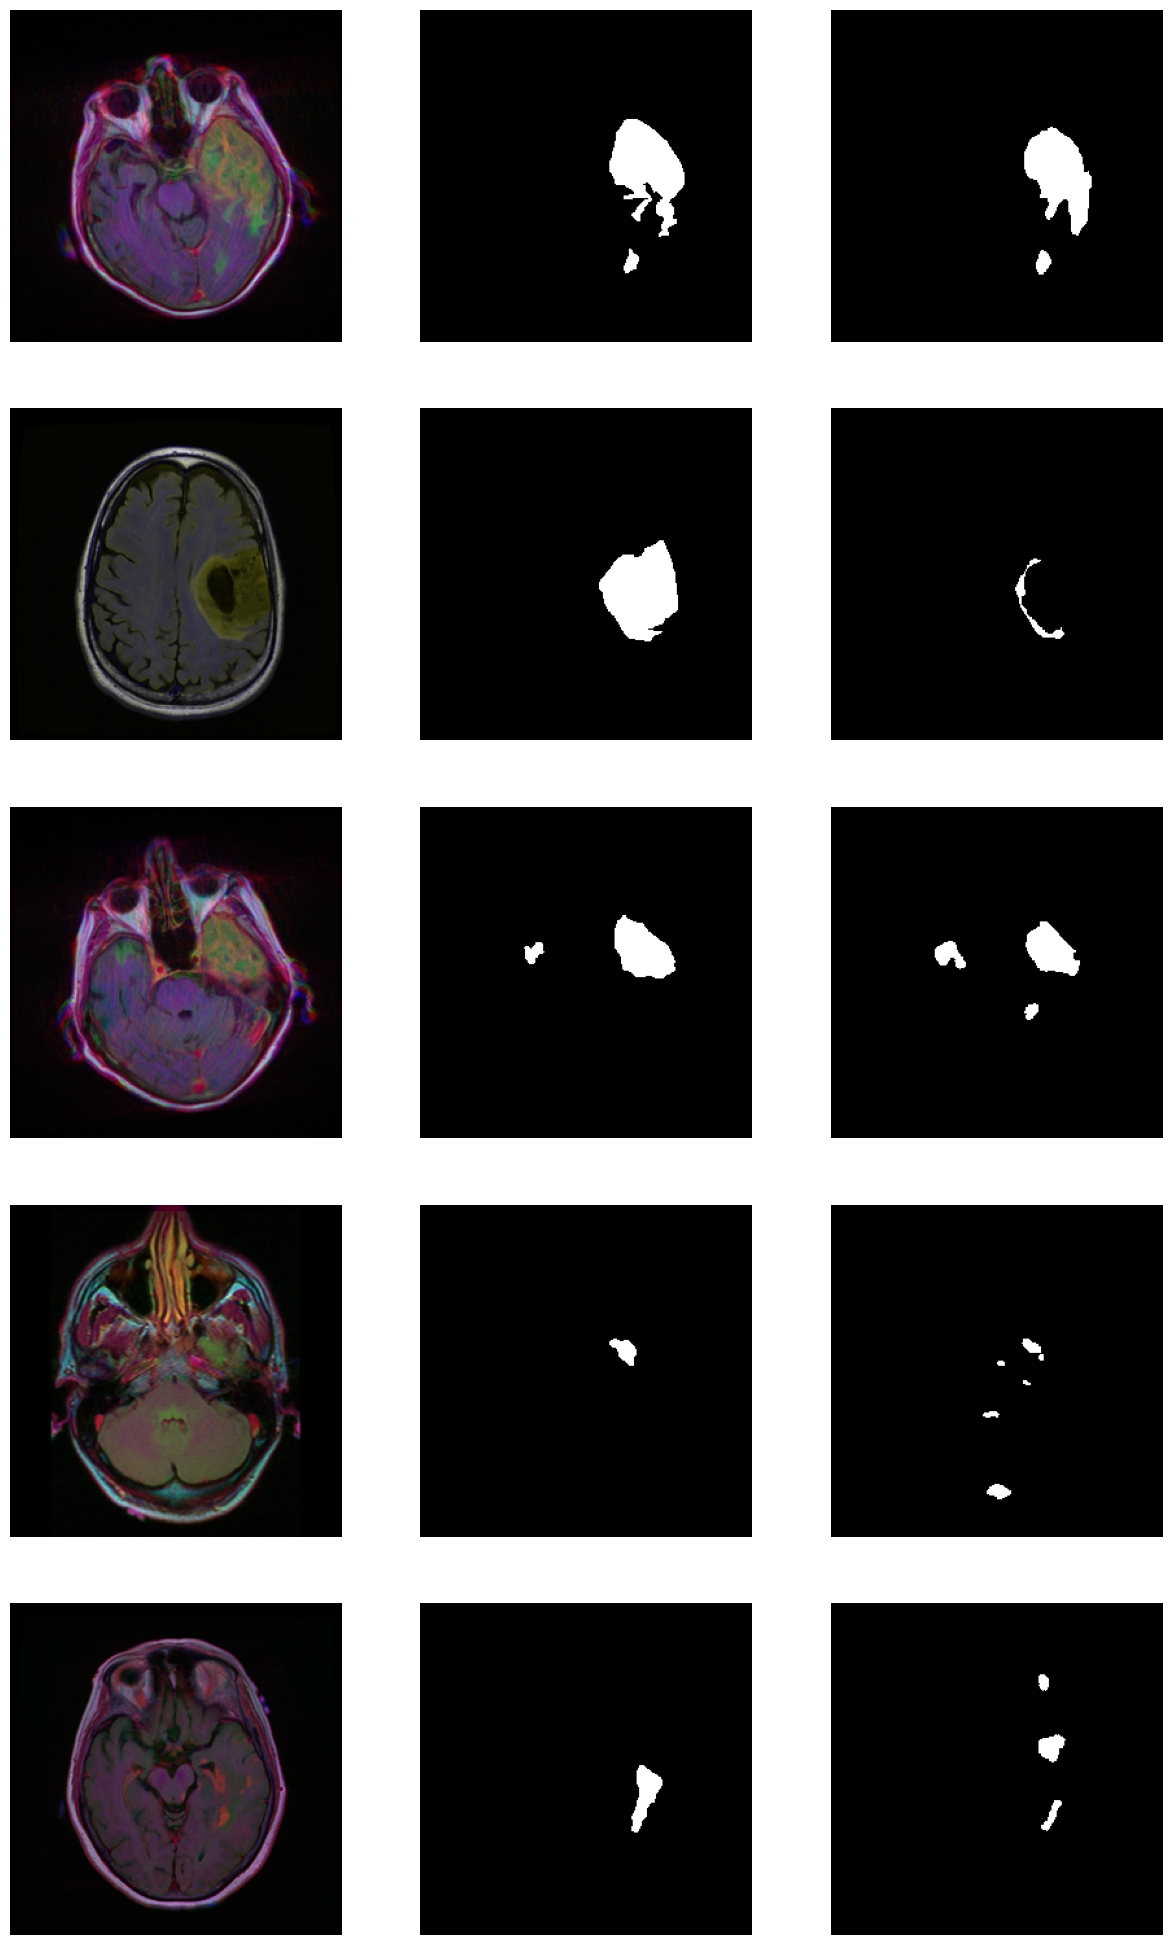

In [27]:


'''
    # Ensure enough samples exist in both categories
    tumor_indices = random.sample(tumor_indices, min(num_per_class, len(tumor_indices)))
    non_tumor_indices = random.sample(non_tumor_indices, min(num_per_class, len(non_tumor_indices)))

    selected_indices = tumor_indices + non_tumor_indices
    total_samples = len(selected_indices)

    plt.figure(figsize=(12, total_samples * 2.5))

    for i, idx in enumerate(selected_indices):
        image = X_test[idx]
        true_mask = y_test[idx]

        # Predict mask
        pred_mask = model.predict(np.expand_dims(image, axis=0))[0]
        pred_mask = (pred_mask > 0.5).astype(np.uint8)
        pred_mask = adaptive_morphology(pred_mask)  # Shrink mask

        # Titles
        label = "Tumor" if np.any(true_mask > 0) else "Non-Tumor"

        # Original MRI
        plt.subplot(total_samples, 3, i*3 + 1)
        plt.imshow(image)
        plt.title(f"{label} - MRI")
        plt.axis("off")

        # Ground truth mask
        plt.subplot(total_samples, 3, i*3 + 2)
        plt.imshow(true_mask.squeeze(), cmap='gray')
        plt.title("Ground Truth")
        plt.axis("off")

        # Predicted mask
        plt.subplot(total_samples, 3, i*3 + 3)
        plt.imshow(pred_mask.squeeze(), cmap='gray')
        plt.title("Predicted Mask")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Run visualization
visualize_predictions(model, X_test, y_test, num_per_class=4)
'''
selected_routes=brain_df_mask_test.sample(5)

plt.figure(figsize=(15,25))
for i in range(len(selected_routes)):

  plt.subplot(5,3,1+3*(i))
  image = cv2.cvtColor(io.imread(selected_routes.image_path.iloc[i]), cv2.COLOR_BGR2RGB)/255
  plt.imshow(image)
  plt.axis('off')

  plt.subplot(5,3,2+3*(i))
  true_mask = cv2.cvtColor(io.imread(selected_routes.mask_path.iloc[i]), cv2.COLOR_BGR2RGB)/255
  plt.imshow(true_mask)
  plt.axis('off')


  plt.subplot(5,3,3+3*(i))
  pred_mask=model_seg.predict(np.expand_dims(image, axis=0))[0]
  pred_mask = (pred_mask > 0.5).astype(np.uint8)
  pred_mask = adaptive_morphology(pred_mask)  # Shrink mask
  plt.imshow(pred_mask, cmap='gray')
  plt.axis('off')


In [28]:
# Generate predictions for all test images
image_id = []
mask = []
has_mask = []

print("Generating predictions for test set...")
for i in range(len(brain_df_mask_test)):
    # Get image path
    img_path = brain_df_mask_test.image_path.iloc[i]

    # Read and preprocess image
    image = cv2.cvtColor(io.imread(img_path), cv2.COLOR_BGR2RGB) / 255.0

    # Predict mask
    pred_mask = loaded_model_seg.predict(np.expand_dims(image, axis=0), verbose=0)[0]
    pred_mask = (pred_mask > 0.5).astype(np.uint8)
    pred_mask = adaptive_morphology(pred_mask)  # Shrink mask

    # Store results
    image_id.append(img_path)
    mask.append(pred_mask)
    has_mask.append(1)  # All images in brain_df_mask_test have masks

    if (i + 1) % 20 == 0:
        print(f"Processed {i + 1}/{len(brain_df_mask_test)} images")

print(f"Completed! Generated predictions for {len(image_id)} images.")

Generating predictions for test set...
Processed 20/129 images
Processed 40/129 images
Processed 60/129 images
Processed 80/129 images
Processed 100/129 images
Processed 120/129 images
Completed! Generated predictions for 129 images.


In [29]:
# creating a dataframe for the result
df_pred = pd.DataFrame({'image_path': image_id,'predicted_mask': mask,'has_mask': has_mask})
df_pred

image_path  \
0    ./data/TCGA_CS_4941_19960909/TCGA_CS_4941_1996...   
1    ./data/TCGA_CS_4941_19960909/TCGA_CS_4941_1996...   
2    ./data/TCGA_CS_4941_19960909/TCGA_CS_4941_1996...   
3    ./data/TCGA_CS_4941_19960909/TCGA_CS_4941_1996...   
4    ./data/TCGA_CS_4941_19960909/TCGA_CS_4941_1996...   
..                                                 ...   
124  ./data/TCGA_HT_7882_19970125/TCGA_HT_7882_1997...   
125  ./data/TCGA_HT_7882_19970125/TCGA_HT_7882_1997...   
126  ./data/TCGA_HT_7882_19970125/TCGA_HT_7882_1997...   
127  ./data/TCGA_HT_7882_19970125/TCGA_HT_7882_1997...   
128  ./data/TCGA_HT_7882_19970125/TCGA_HT_7882_1997...   

                                        predicted_mask  has_mask  
0    [[[0], [0], [0], [0], [0], [0], [0], [0], [0],...         1  
1    [[[0], [0], [0], [0], [0], [0], [0], [0], [0],...         1  
2    [[[0], [0], [0], [0], [0], [0], [0], [0], [0],...         1  
3    [[[0], [0], [0], [0], [0], [0], [0], [0], [0],...         1  
4    [[[0], [0], [0], [0], [0], [0], [0], [0], [0],...         1  
..                                                 ...       ...  
124  [[[0], [0], [0], [0], [0], [0], [0], [0], [0],...         1  
125  [[[0], [0], [0], [0], [0], [0], [0], [0], [0],...         1  
126  [[[0], [0], [0], [0], [0], [0], [0], [0], [0],...         1  
127  [[[0], [0], [0], [0], [0], [0], [0], [0], [0],...         1  
128  [[[0], [0], [0], [0], [0], [0], [0], [0], [0],...         1  

[129 rows x 3 columns]

In [30]:
# Merge the dataframe containing predicted results with the original test data.
df_pred = brain_df_mask_test.merge(df_pred, on='image_path')
df_pred.head()

image_path  \
0  ./data/TCGA_CS_4941_19960909/TCGA_CS_4941_1996...   
1  ./data/TCGA_CS_4941_19960909/TCGA_CS_4941_1996...   
2  ./data/TCGA_CS_4941_19960909/TCGA_CS_4941_1996...   
3  ./data/TCGA_CS_4941_19960909/TCGA_CS_4941_1996...   
4  ./data/TCGA_CS_4941_19960909/TCGA_CS_4941_1996...   

                                           mask_path  mask    patient_id  \
0  ./data/TCGA_CS_4941_19960909/TCGA_CS_4941_1996...     1  TCGA_CS_4941   
1  ./data/TCGA_CS_4941_19960909/TCGA_CS_4941_1996...     1  TCGA_CS_4941   
2  ./data/TCGA_CS_4941_19960909/TCGA_CS_4941_1996...     1  TCGA_CS_4941   
3  ./data/TCGA_CS_4941_19960909/TCGA_CS_4941_1996...     1  TCGA_CS_4941   
4  ./data/TCGA_CS_4941_19960909/TCGA_CS_4941_1996...     1  TCGA_CS_4941   

                                      predicted_mask  has_mask  
0  [[[0], [0], [0], [0], [0], [0], [0], [0], [0],...         1  
1  [[[0], [0], [0], [0], [0], [0], [0], [0], [0],...         1  
2  [[[0], [0], [0], [0], [0], [0], [0], [0], [0],...         1  
3  [[[0], [0], [0], [0], [0], [0], [0], [0], [0],...         1  
4  [[[0], [0], [0], [0], [0], [0], [0], [0], [0],...         1

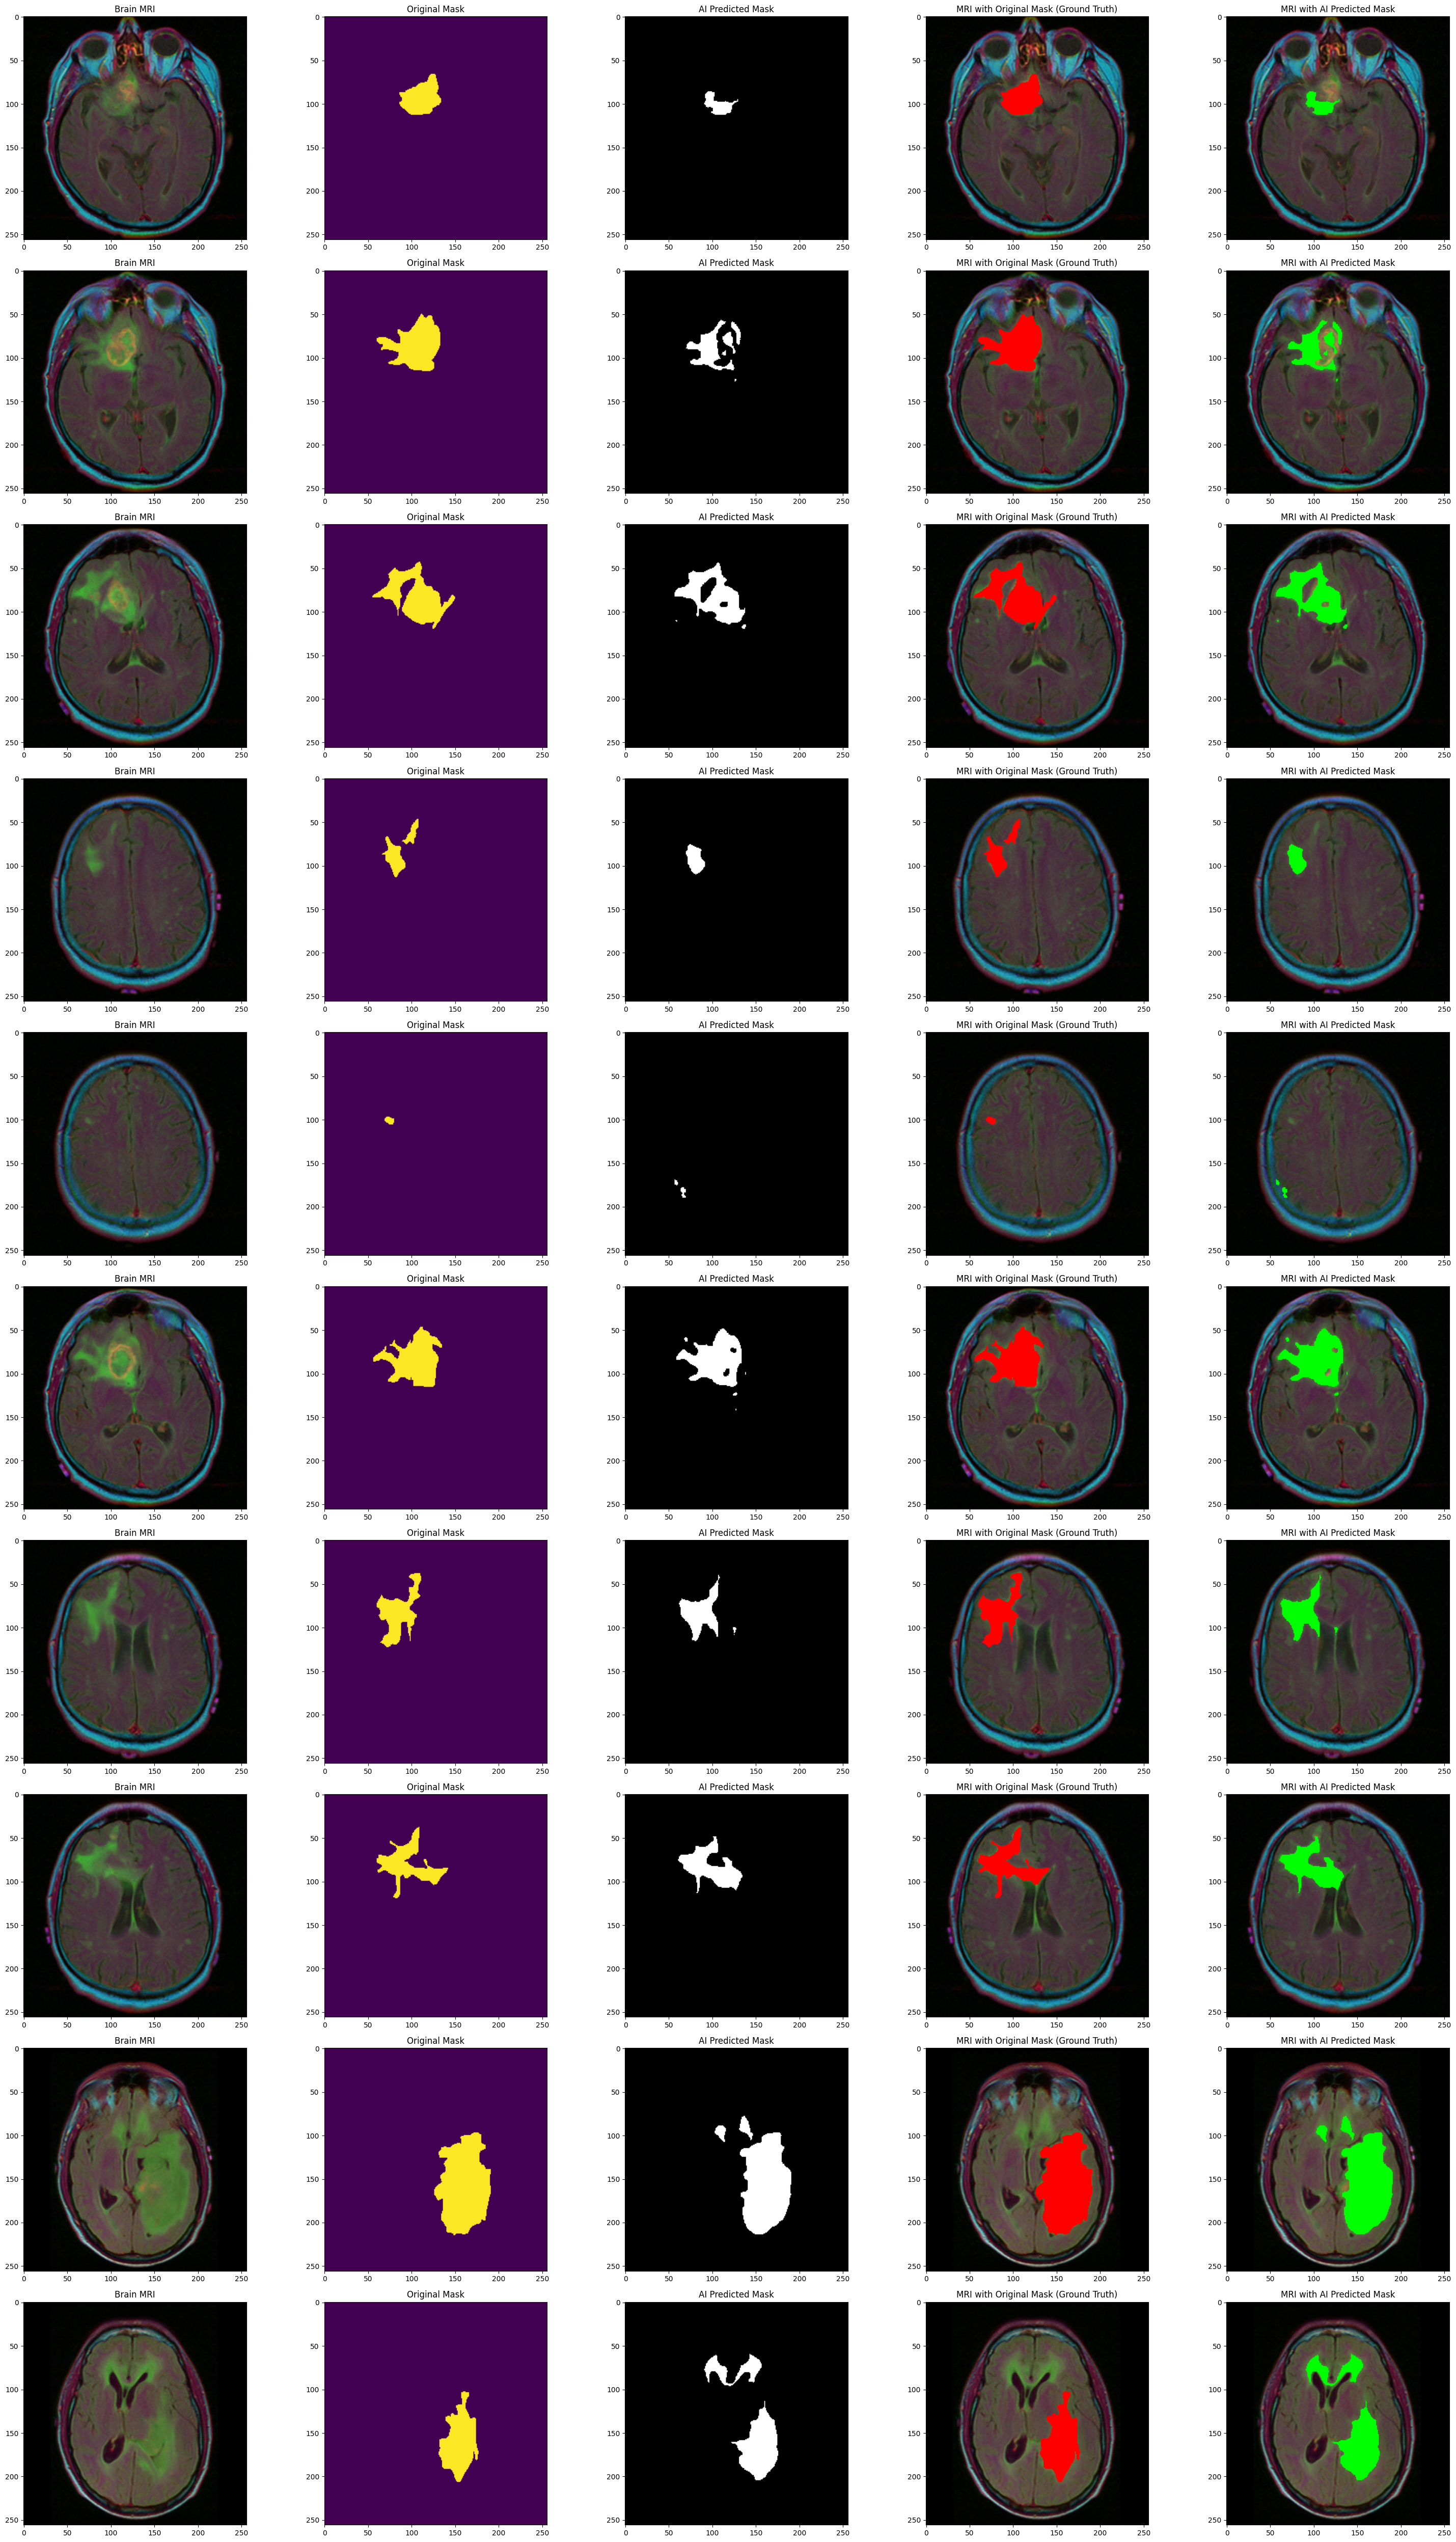

In [31]:
count = 0
fig, axs = plt.subplots(10, 5, figsize=(30, 50))
for i in range(len(df_pred)):
  if df_pred['has_mask'][i] == 1 and count < 10:
    # read the images and convert them to RGB format
    img = io.imread(df_pred.image_path[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axs[count][0].title.set_text("Brain MRI")
    axs[count][0].imshow(img)

    # Obtain the mask for the image
    mask = io.imread(df_pred.mask_path[i])
    axs[count][1].title.set_text("Original Mask")
    axs[count][1].imshow(mask)

    # Obtain the predicted mask for the image
    predicted_mask = np.array(df_pred.predicted_mask[i])
    # Ensure it's 2D (256, 256)
    if predicted_mask.ndim > 2:
        predicted_mask = predicted_mask.squeeze()
    if predicted_mask.ndim == 1:
        # If somehow flattened, reshape it
        predicted_mask = predicted_mask.reshape(256, 256)
    predicted_mask = predicted_mask.round().astype(np.uint8)
    axs[count][2].title.set_text("AI Predicted Mask")
    axs[count][2].imshow(predicted_mask, cmap='gray')

    # Apply the mask to the image 'mask==255'
    img[mask == 255] = (255, 0, 0)
    axs[count][3].title.set_text("MRI with Original Mask (Ground Truth)")
    axs[count][3].imshow(img)

    img_ = io.imread(df_pred.image_path[i])
    img_ = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
    img_[predicted_mask == 1] = (0, 255, 0)
    axs[count][4].title.set_text("MRI with AI Predicted Mask")
    axs[count][4].imshow(img_)
    count += 1

fig.tight_layout()

MINI CHALLENGE:
- Plot 30 images along with their corresponding mask
- Visually verify that model predictions made sense

# EXCELLENT JOB! NOW YOU KNOW HOW TO APPLY AI TO DETECT AND LOCALIZE BRAIN TUMORS. THIS IS A GREAT ACHIEVEMENT IN HEALTHCARE.

# MINI CHALLENGE SOLUTIONS

MINI CHALLENGE #1

In [32]:
# Obtain the number of images with mask
brain_df['mask'].value_counts()

mask
0    2533
1    1366
Name: count, dtype: int64

MINI CHALLENGE #2

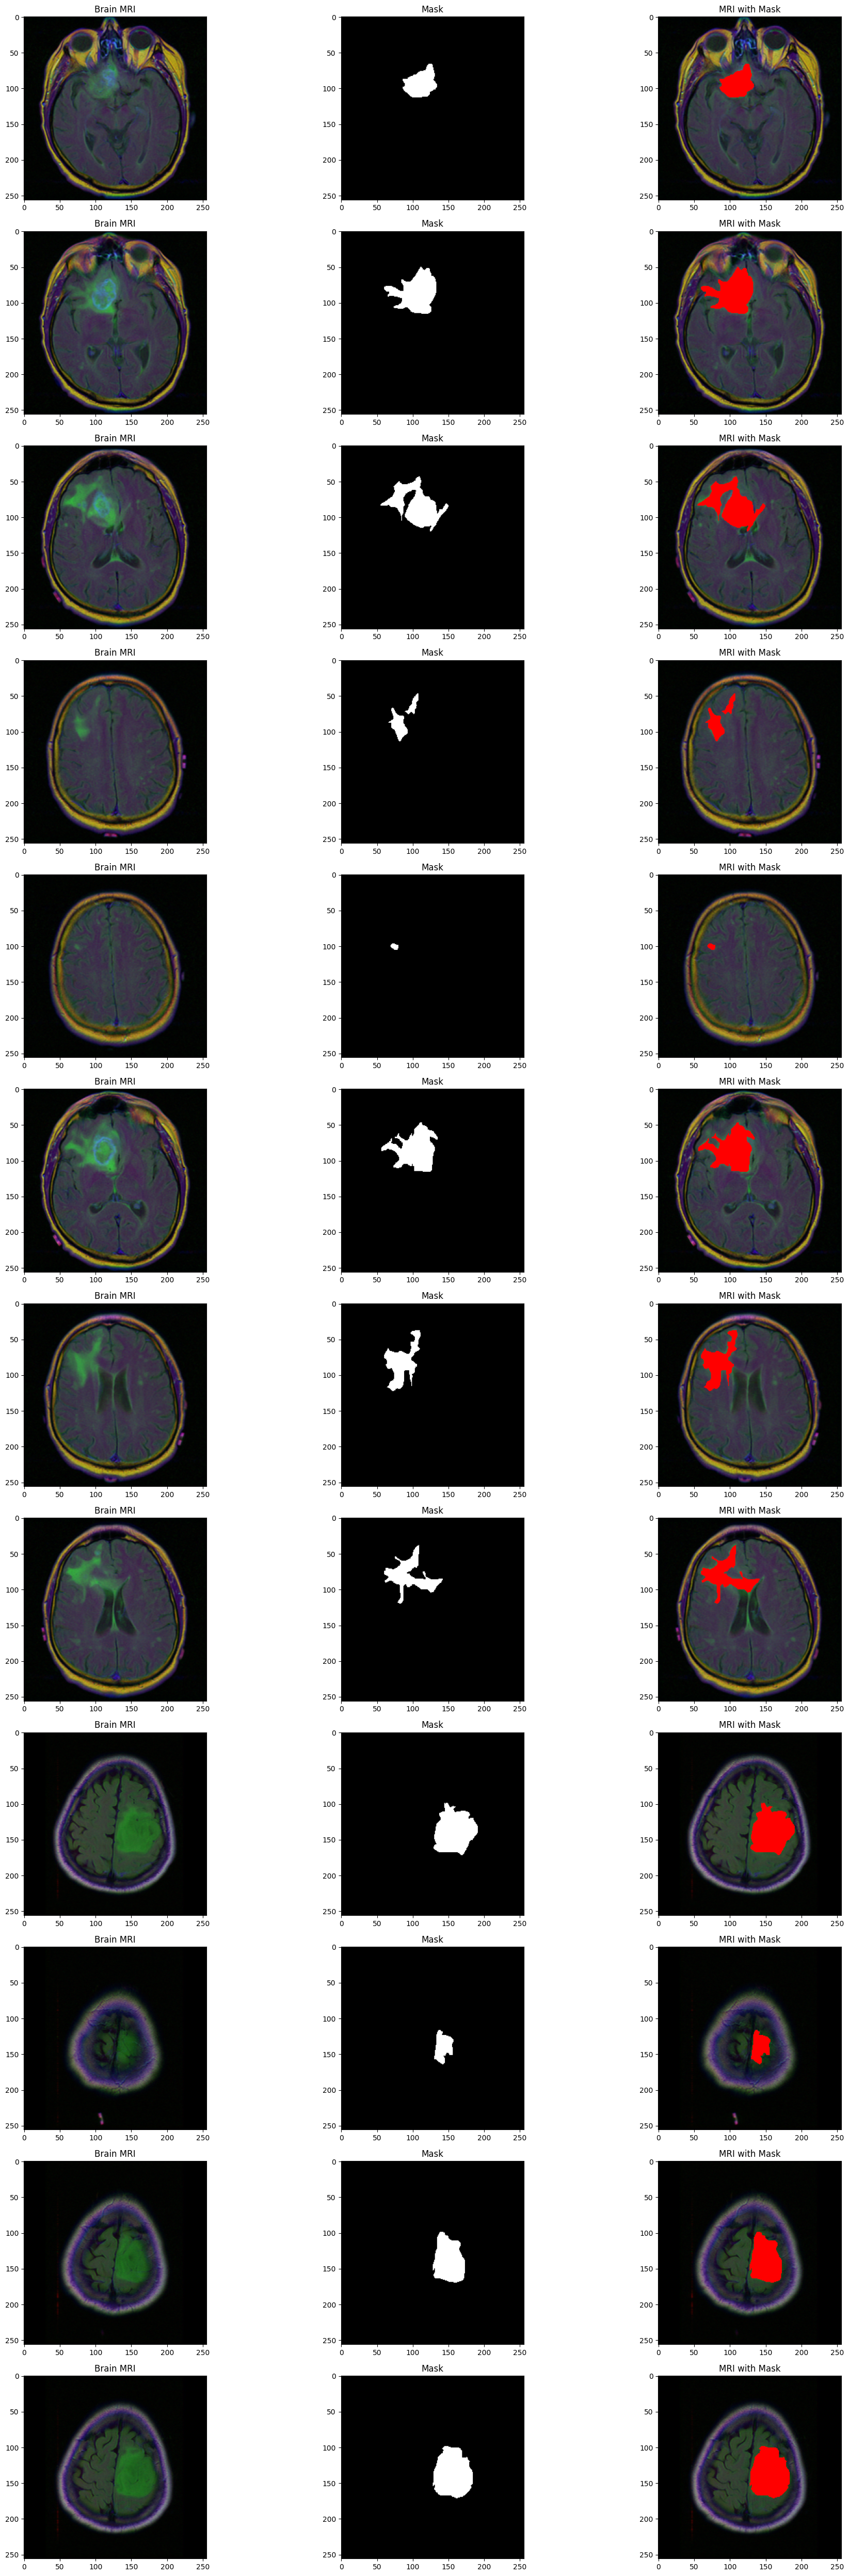

In [33]:
# Advanced Visualization: visualize the MRI scans along with their mask on one image
count = 0
fig, axs = plt.subplots(12,3, figsize=(20,50))
for i in range(len(brain_df)):
  if brain_df['mask'][i] == 1 and count < 12:
  # read the images
    img = io.imread(brain_df.image_path[i])
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axs[count][0].title.set_text("Brain MRI")
    axs[count][0].imshow(img)

    # obtain the mask for the image
    mask = io.imread(brain_df.mask_path[i])
    axs[count][1].title.set_text("Mask")
    axs[count][1].imshow(mask, cmap = 'gray')

    # replace the values in the image with red color (255,0,0) if any mask pixel in the mask was = 255
    img[mask == 255] = (255,0,0)
    axs[count][2].title.set_text("MRI with Mask")
    axs[count][2].imshow(img)
    count += 1

fig.tight_layout()

MINI CHALLENGE #3:

- An ensemble of these residual nets achieves 3.57% error
on the ImageNet test set.
- Solution (great article by Siddharth Das): https://medium.com/analytics-vidhya/cnns-architectures-lenet-alexnet-vgg-googlenet-resnet-and-more-666091488df5

MINI CHALLENGE #4:
- Negative Transfer occurs when transfer learning negatively affect the model. This occurs when the features of old and new tasks are not related.  
- Transfer bounds: Measuring the amount of knowledge transfered is crucial to ensure model quality and robustness.

MINI CHALLENGE #5:

In [34]:
# Add classification head to the base model

headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size = (4,4))(headmodel)
headmodel = Flatten(name= 'flatten')(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(2, activation = 'softmax')(headmodel)

model = Model(inputs = basemodel.input, outputs = headmodel)

NameError: name 'basemodel' is not defined

In [ ]:
# Total parameters (original model) = 25,685,634
# Total parameters (New model with added dense and dropout layers) = 25,751,426

MINI CHALLENGE #6:

In [ ]:

from sklearn.metrics import classification_report

report = classification_report(original,predict, labels = [0,1])
print(report)

MINI CHALLENGE #7:


- Total params: 1,210,513

MINI CHALLENGE #8:

In [ ]:
count = 0
fig, axs = plt.subplots(30, 5, figsize=(60, 100))
for i in range(len(df_pred)):
  if df_pred['has_mask'][i] == 1 and count < 30:

# TASK #7: ASSESS TRAINED MODEL PERFORMANCE

In [ ]:
# Load pretrained model (instead of training the model for 1+ hours)

model=load_model('./classifier-resnet-model6.keras')


In [ ]:
# === ENHANCED 8-WAY TEST TIME AUGMENTATION ===
# Uses H-Flip, V-Flip, and 90° rotations for robust predictions

import numpy as np

def enhanced_tta_predict(model, image, threshold=0.5):
    '''
    8-way TTA: Original + H-Flip + V-Flip + HV-Flip + 4 Rotations
    Averages probability maps before thresholding.
    
    Args:
        model: Trained Keras model
        image: Single image (H, W, C)
        threshold: Binary threshold for final mask
    '''
    preds = []
    img = image[np.newaxis, ...]  # Add batch dim
    
    # 1. Original
    preds.append(model.predict(img, verbose=0)[0])
    
    # 2. Horizontal Flip
    h_flip = np.flip(image, axis=1)
    pred = model.predict(h_flip[np.newaxis, ...], verbose=0)[0]
    preds.append(np.flip(pred, axis=1))
    
    # 3. Vertical Flip
    v_flip = np.flip(image, axis=0)
    pred = model.predict(v_flip[np.newaxis, ...], verbose=0)[0]
    preds.append(np.flip(pred, axis=0))
    
    # 4. Both Flips
    hv_flip = np.flip(np.flip(image, axis=1), axis=0)
    pred = model.predict(hv_flip[np.newaxis, ...], verbose=0)[0]
    preds.append(np.flip(np.flip(pred, axis=1), axis=0))
    
    # 5-8. 90° Rotations (k=1,2,3)
    for k in [1, 2, 3]:
        rotated = np.rot90(image, k)
        pred = model.predict(rotated[np.newaxis, ...], verbose=0)[0]
        preds.append(np.rot90(pred, -k))
    
    # Average all predictions
    avg_pred = np.mean(preds, axis=0)
    
    # Apply threshold
    binary_mask = (avg_pred > threshold).astype(np.uint8)
    
    # Apply adaptive morphology
    final_mask = adaptive_morphology(binary_mask)
    
    return final_mask, avg_pred  # Return both binary and probability

print('Enhanced 8-way TTA ready.')

# === BATCH TTA FOR TEST SET ===

def tta_predict_batch(model, images, threshold=0.5):
    '''
    Apply enhanced TTA to a batch of images.
    '''
    results = []
    for i in range(len(images)):
        mask, _ = enhanced_tta_predict(model, images[i], threshold)
        results.append(mask)
    return np.array(results)

def tta_predict_generator(model, generator, steps):
    '''
    Apply enhanced TTA to a generator.
    '''
    print(f'Applying 8-way TTA on {steps} batches...')
    outputs = []
    
    for i in range(steps):
        batch = next(generator)
        if isinstance(batch, tuple):
            x = batch[0]
        else:
            x = batch
        
        # Apply TTA to each image in batch
        batch_preds = tta_predict_batch(model, x, threshold=0.5)
        outputs.append(batch_preds)
        
        if i % 10 == 0:
            print(f'Processed batch {i}/{steps}')
    
    return np.concatenate(outputs, axis=0)

print('Batch TTA functions ready.')


In [ ]:
# make prediction

test_predict = tta_predict_generator(model, test_generator, steps = test_generator.n // 16)


In [ ]:
test_predict.shape

In [ ]:
test_predict

In [ ]:
# Obtain the predicted class from the model prediction
predict = []

for i in test_predict:
  predict.append(str(np.argmax(i)))

predict = np.asarray(predict)

In [ ]:
predict

In [ ]:
# since we have used test generator, it limited the images to len(predict), due to batch size
original = np.asarray(test['mask'])[:len(predict)]
len(original)

In [ ]:
# Obtain the accuracy of the model
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(original, predict)
accuracy

In [ ]:
# plot the confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(original, predict)
plt.figure(figsize = (7,7))
sns.heatmap(cm, annot=True,)

MINI CHALLENGE #6:
- Print out the classification report and comment on the precision, recall and F1-score results

In [ ]:
from sklearn.metrics import classification_report

report = classification_report(original, predict, labels = [0,1])
print(report)

# TRAINED MODEL TESTING

In [ ]:
# Load pretrained modeL

model=load_model('./classifier-resnet-model9.keras')


In [ ]:
test_predict = model.predict(test_generator, steps = test_generator.n // 16, verbose =1)

In [ ]:
# Obtain the predicted class from the model prediction
predict = []

for i in test_predict:
  predict.append(str(np.argmax(i)))

predict = np.asarray(predict)
predict = predict.astype("object")

In [ ]:
# since we have used test generator, it limited the images to len(predict), due to batch size
original = np.asarray(test['mask'])[:len(predict)]
len(original)

In [ ]:
# Obtain the accuracy of the model

print("accuracy_score: ", accuracy_score(original, predict))
print("f1_score: ", f1_score(original, predict,pos_label="1"))
print("precision_score: ", precision_score(original, predict,pos_label="1"))
print("recall_score: ", recall_score(original, predict,pos_label="1"))

In [ ]:
from sklearn.metrics import classification_report

report = classification_report(original, predict, labels = [0,1])
print(report)

In [ ]:
# plot the confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(original, predict)
plt.figure(figsize = (7,7))
sns.heatmap(cm, annot=True, fmt="d");

In [ ]:
original=original.astype("int")
predict=predict.astype("int")
RocCurveDisplay.from_predictions(original, predict);
